# 1 Keras 분류


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras
import os
import multiprocessing

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 비활성화 (CPU 모드 강제)
num_cores = multiprocessing.cpu_count()

tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

from sklearn.model_selection import train_test_split

## (1)Fashin MNIST 데이터 세트

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 사용하겠습니다.


패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.


패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.


패션 MNIST 데이터셋은 10종류의 패션 아이템으로 구성되어 있다.

 - MNIST 데이터는 손으로 쓴 0 ~ 9 까지의 숫자로 이루어져 있다.
 - 패션 MNIST는 MNIST와 크기, 개수가 동일하지만 숫자 대신 패션 아이템으로 이루져있다.



이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

<div align='center'>
  <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="400">   
  <div align="center">     <b>그림 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br>{nbsp}   </div>
</div>



#### -plot 함수

In [3]:
def plot_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [4]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


여기에서 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가합니다. TensorFlow에서 직접 Fashion MNIST에 액세스할 수 있습니다. TensorFlow에서 직접 [Fashion MNIST 데이터](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)를 가져오고 로드합니다.

In [5]:
(train_images, train_labels), (test_images, test_labels) = \
    keras.datasets.fashion_mnist.load_data()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

패션 MNIST의 타깃은 0 ~ 9까지의 숫자 레이블로 구성된다. 각 숫자의 의미는 아직 모르지만 마지막 2개의 샘플이 같은 레이블(5)를 가지고 있다. 패션 MNIST에 포함된 10개의 레이블의 의미는 다음과 같다.

0 : 티셔츠
1 : 바지
2 : 스웨터
3 : 드레스
4 : 코트
5 : 샌달
6 : 셔츠
7 : 스니커즈
8 : 가방
9 : 앵클 부츠

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

마지막으로 넘파이 unique() 함수로 레이블 당 샘플 개수를 확인해 보자.

In [8]:
# 전체 학습 데이터 타겟의 라벨만 출력
print(np.unique(train_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

크기가 28 x 28이다 보니 꽤 작고 흐릿하다. 신발과 다양한 종류의 옷들이 보인다.


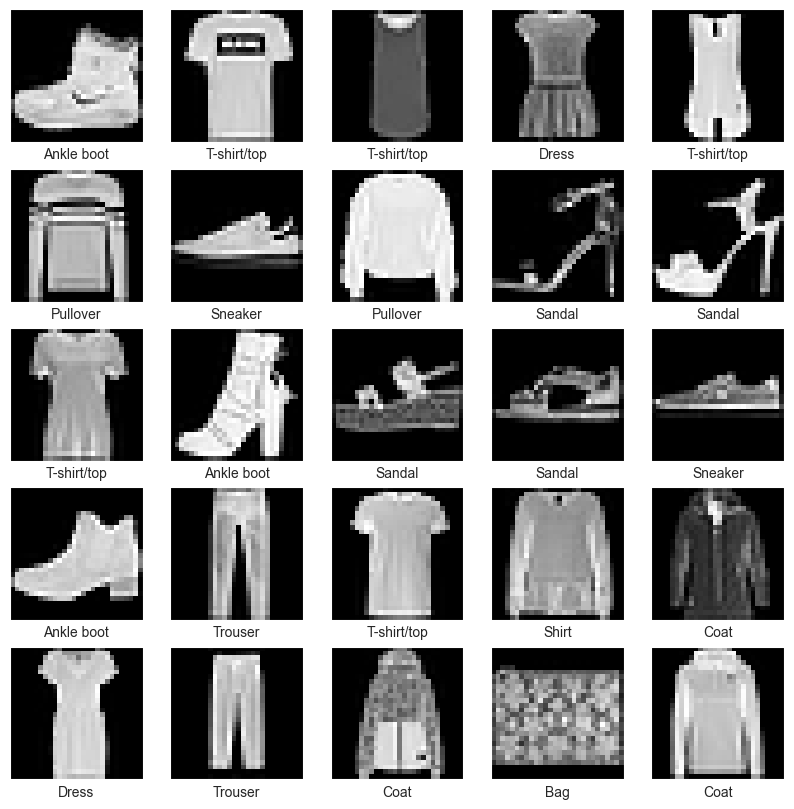

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## (2)데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

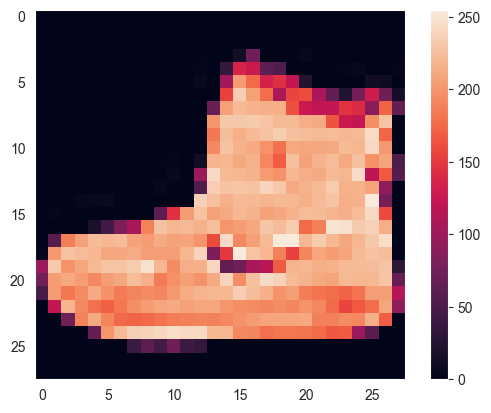

In [11]:
# image 0
plot_img(train_images[0])

In [12]:
train_images[0].min(), train_images[0].max()

(0, 255)

In [13]:
train_images[0].shape

(28, 28)

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:


> 28 x 28 크기의 2차원 배열을 784 크기의 1차원 배열로 펼쳐 입력하지만 여기서는 Flattent layer 를 사용하겠다.



In [14]:
# 정규화
train_scaled = train_images / 255.0
test_scaled = test_images / 255.0

# 28x28 이미지를 784개 벡터로 변경
# train_scaled = train_scaled.reshape(-1, 28*28)

## (3)학습


In [15]:
model = keras.Sequential([
    keras.layers.Input((28,28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
from tqdm.keras import TqdmCallback

history = model.fit(
    train_scaled,
    train_labels,
    epochs=100,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.7786 - loss: 0.6386
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - accuracy: 0.8584 - loss: 0.3848
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0.8756 - loss: 0.3436
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.8819 - loss: 0.3231
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.8887 - loss: 0.3087
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.8930 - loss: 0.2977
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8971 - loss: 0.2931
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.9007 - loss: 0.2831
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.9038 - loss: 0.2758
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.9082 - loss: 0.2702
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.9080 - loss: 0.26

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

In [20]:
# Test set
print("Test 데이터로 모델 평가:")

loss, accuracy = model.evaluate(test_scaled, test_labels)

print(f"테스트 손실: {loss:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")

Test 데이터로 모델 평가:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8804 - loss: 1.1043
테스트 손실: 1.0983
테스트 정확도: 0.8802



fit 에 반환되는 history 에는 `history.history` 딕트 속성에 손실/정확도 듣의 metircs 지표 값이 저장되어 있다.

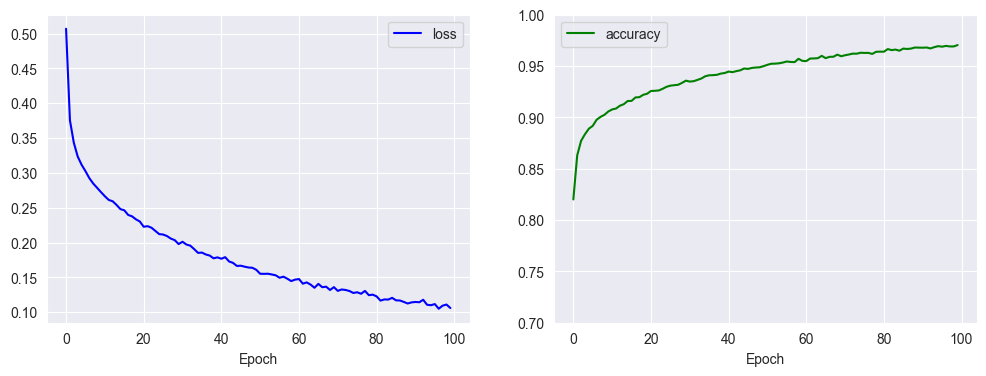

In [21]:
# Fashion MNIST 분류 모델 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')

plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

## (4) 예측

#### -전체 테스트 데이터
전체 테스트 데이터를 대상으로 예측을 수행하자

In [22]:
pred = model.predict(test_scaled)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


전체 테스트 데이터를 예측한 pred는 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence) 이다

In [23]:
# 위치 0
pred[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7919111e-37,
       0.0000000e+00, 1.6308202e-21, 0.0000000e+00, 2.5657122e-11,
       1.7106116e-28, 1.0000000e+00], dtype=float32)

In [24]:
# 위치 0 argmax
np.argmax(pred[100])

3

In [25]:
# 위치 0 class name
class_names[np.argmax(pred[100])]

'Dress'

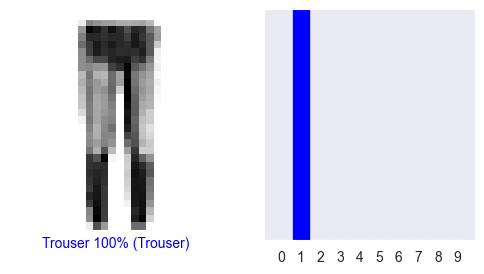

In [26]:
i = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, pred[i], test_labels, test_images)

plt.subplot(1,2,2)
plot_value_array(i, pred[i], test_labels)

plt.show()

## Validation

### 훈련 / 검증세트 분할

 사이킷런의 train_test_split() 함수로 훈련 세트와 검증 세트로 나눈다.

In [27]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_labels, val_target = train_test_split(
    train_scaled, train_labels, test_size=0.2, random_state=42)

In [28]:
model2 = keras.Sequential([
    keras.layers.Input((28,28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [29]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history2 = model2.fit(train_scaled, train_labels, epochs=30, validation_data=[val_scaled, val_target])
history2 = model2.fit(train_scaled, train_labels, epochs=30, validation_split=.2)


Epoch 1/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7647 - loss: 0.6786 - val_accuracy: 0.8380 - val_loss: 0.4371
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8500 - loss: 0.4180 - val_accuracy: 0.8572 - val_loss: 0.3859
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8733 - loss: 0.3637 - val_accuracy: 0.8667 - val_loss: 0.3674
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.8753 - loss: 0.3390 - val_accuracy: 0.8618 - val_loss: 0.3711
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8836 - loss: 0.3198 - val_accuracy: 0.8720 - val_loss: 0.3550
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - accuracy: 0.8884 - loss: 0.3075 - val_accuracy: 0.8653 - val_loss: 0.3730
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.8967 - loss: 0.2945 - val_accuracy: 0.8742 - val_loss: 0.3559
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.8980 - l

In [31]:
# Test set
print("model2 Test 데이터로 모델 평가:")

loss, accuracy = model2.evaluate(test_scaled, test_labels)

print(f"테스트 손실: {loss:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")

model2 Test 데이터로 모델 평가:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.8730 - loss: 0.5535
테스트 손실: 0.5427
테스트 정확도: 0.8716


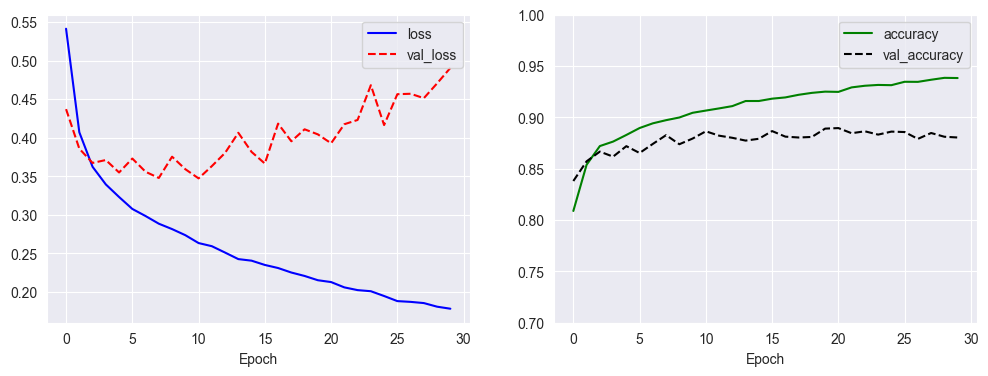

In [32]:
# Fashion MNIST 분류 모델 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], 'b-', label='loss')
plt.plot(history2.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], 'g-', label='accuracy')
plt.plot(history2.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

### 예측

In [33]:
img = test_images[100]
img.shape

(28, 28)

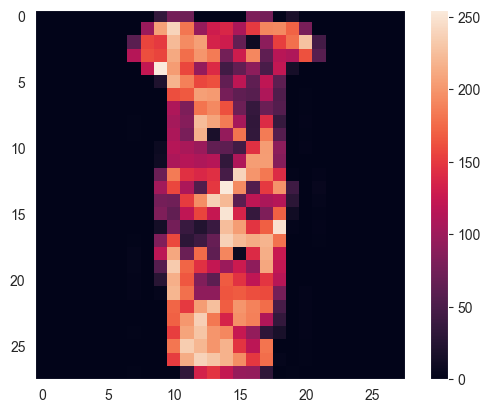

In [34]:
plot_img(img)

In [35]:
img.reshape(-1, 28, 28).shape

(1, 28, 28)

In [36]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 28, 28)

예측 모델을 사용해서 선택한 샘플 이미지가 무엇인지 예측을 수행한다. `tf.keras.Model.predict` 는 데이터 배치의 각 이미지에 대해 하나의 목록씩 목록의 목록을 반환합니다. 배치에서 (유일한) 이미지에 대한 예측을 가져옵니다.

In [37]:
pred1 = model2.predict(img)
pred1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [38]:
class_names[np.argmax(pred1[0])]

'Dress'

# 실습

은닉층을 하나 더 추가해 성능 향상이 있는지 알아보자

In [39]:
model3 = keras.Sequential([
    keras.layers.Input((28,28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [40]:
model3.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_scaled, train_labels, epochs=30, validation_split=.2)

Epoch 1/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.7550 - loss: 0.6844 - val_accuracy: 0.8388 - val_loss: 0.4345
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8531 - loss: 0.4033 - val_accuracy: 0.8500 - val_loss: 0.4147
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8718 - loss: 0.3543 - val_accuracy: 0.8696 - val_loss: 0.3666
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.8772 - loss: 0.3401 - val_accuracy: 0.8755 - val_loss: 0.3487
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.8825 - loss: 0.3257 - val_accuracy: 0.8772 - val_loss: 0.3694
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.8899 - loss: 0.3095 - val_accuracy: 0.8721 - val_loss: 0.3839
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8894 - loss: 0.3020 - val_accuracy: 0.8834 - val_loss: 0.3576
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8934 -

In [41]:
print("model3 Test 데이터로 모델 평가:")
loss, accuracy = model3.evaluate(test_scaled, test_labels)
print(f"테스트 손실: {loss:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")

model3 Test 데이터로 모델 평가:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8729 - loss: 0.6427
테스트 손실: 0.6548
테스트 정확도: 0.8740


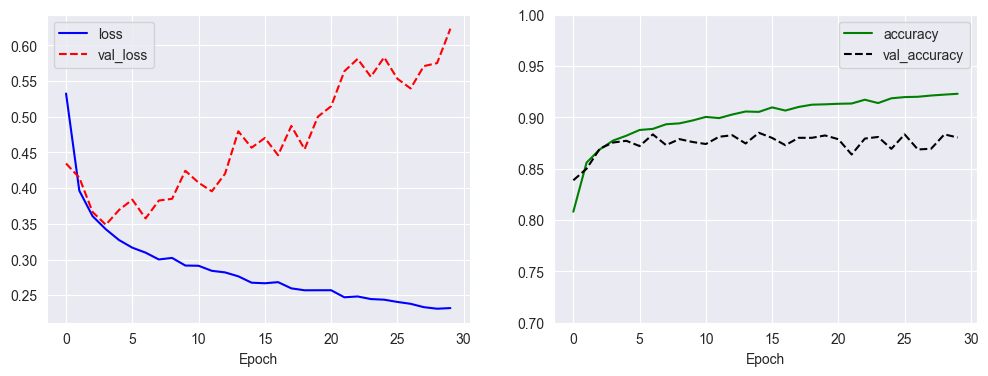

In [42]:
# Fashion MNIST 분류 모델 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], 'b-', label='loss')
plt.plot(history3.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], 'g-', label='accuracy')
plt.plot(history3.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

# "실습"

 - 전체 데이터 (정규화 후)를 사용해서 vadlidation_splits 사용해서 학습해 보세요!!!